In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from filternet.datasets import NCLTFusionDataset, nclt_collate
from filternet.utils import get_path_ckpt_config
from mmengine import Config
from lightning import Trainer
from filternet.registry import MODELS
from filternet.utils import collect_fusion_results, compute_fusion_metric
torch.manual_seed(3407)

In [2]:
dataset = NCLTFusionDataset('../data/nclt_fusion/test.pt')
loader = DataLoader(dataset,collate_fn=nclt_collate, batch_size=128)
for batch in loader:
    break

/data/Project/FIlters/filternet-dev/filternet/datasets/nclt_fusion_dataset.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data.extend(torch.load(p))


In [3]:
len(dataset)

3

In [4]:

path_format = '../runs/nclt_fusion/{model_name}_unsupFalse_{version}/'

trainer = Trainer(accelerator='gpu', devices=[0])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/coco/miniforge3/envs/filternet/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


## KalmanNet Arch1

In [5]:
model_name = 'KNetArch1'
version='v0'
path = path_format.format(model_name=model_name, version=version)
weight_path, cfg_path = get_path_ckpt_config(path, 'min')
config = Config.fromfile(cfg_path)
model = MODELS.build(dict(type = config.TRAINER.type, cfg = config, save_dir = {}))
model

NCLTFusionTrainer(
  (model): NCLTFusionKalmanNetArch1(
    (loss_fn): MSELoss()
    (KG_l1): Linear(in_features=8, out_features=640, bias=True)
    (KG_relu1): ReLU()
    (rnn_GRU): GRU(640, 400, batch_first=True)
    (KG_l2): Linear(in_features=400, out_features=32, bias=True)
    (KG_relu2): ReLU()
    (KG_l3): Linear(in_features=32, out_features=12, bias=True)
  )
  (train_mse_dB): MSEdB()
  (train_rmse): MSE()
  (test_mse_dB): MSEdB()
  (test_rmse): MSE()
  (val_mse_dB): MSEdB()
  (val_rmse): MSE()
)

In [6]:
predictions = trainer.predict(
    model,
    loader,
    ckpt_path=weight_path
)
knet_arch1_collect = collect_fusion_results(
    predictions=predictions)
compute_fusion_metric(knet_arch1_collect)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at ../runs/nclt_fusion/KNetArch1_unsupFalse_v0/checkpoints/epoch=34-val_RMSE=8.03812.ckpt
/home/coco/miniforge3/envs/filternet/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': 'val/RMSE', 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 1, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../runs/nclt

Predicting: |          | 0/? [00:00<?, ?it/s]

2025-05-16 12:25:01,195 - filternet - INFO - 2013-04-05 track_len= 4182, RMSE = 7.087009429931641,  gps_rmse =34.53804397583008
2025-05-16 12:25:01,201 - filternet - INFO - 2012-11-16 track_len= 4917, RMSE = 7.80645227432251,  gps_rmse =19.500930786132812
2025-05-16 12:25:01,205 - filternet - INFO - 2012-11-04 track_len= 4834, RMSE = 15.520000457763672,  gps_rmse =46.1412353515625
2025-05-16 12:25:01,206 - filternet - INFO - avg rmse = 10.13782024383545
2025-05-16 12:25:01,207 - filternet - INFO - rmse4all = 10.961318016052246
2025-05-16 12:25:01,208 - filternet - INFO - avg_gps = 33.393402099609375
2025-05-16 12:25:01,209 - filternet - INFO - rmse4all_gps = 35.08418655395508


tensor(7.8065)


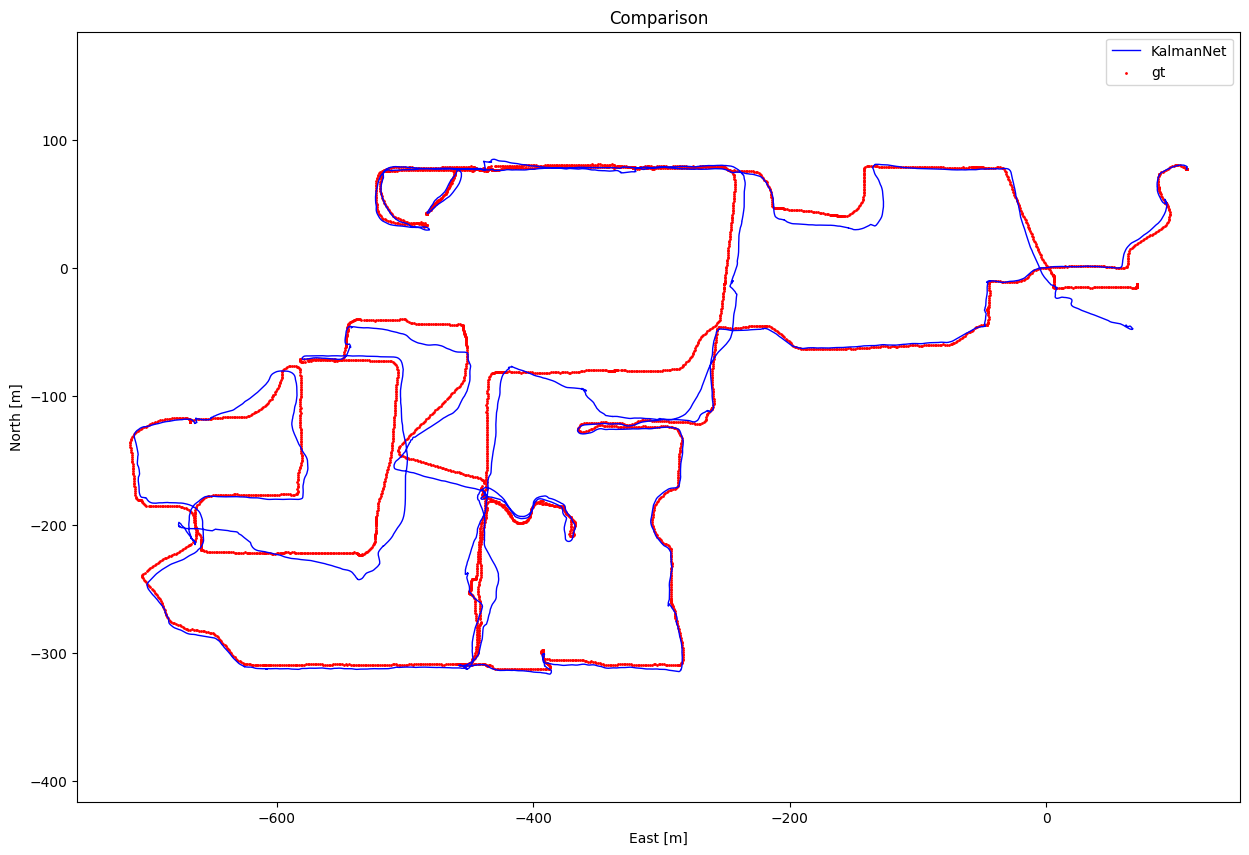

In [7]:
def plot(est, gt, gt_label='gt', est_label='gps'):
    
    y1 = est[1,:]
    x1 = est[0,:]
    x2 = gt[0,:]
    y2 = gt[1, :]
    metric = torch.nn.MSELoss(reduction='mean')
    res = metric(est, gt)
    res = res.sqrt()
    plt.figure(figsize=(15,10))
    plt.plot(y1, x1, c='b', linewidth=1, label=est_label) # plot flipped since North,East
    plt.scatter(y2, x2, c='r', s=1, linewidth=1, label=gt_label)
    plt.axis('equal')
    plt.legend()
    plt.title('Comparison')
    plt.xlabel('East [m]')
    plt.ylabel('North [m]')
    print(res)
time = '2012-11-16'
est = torch.hstack(knet_arch1_collect[time]['preds'])
mask = torch.hstack(knet_arch1_collect[time]['valid_step_mask'])
gt = torch.hstack(knet_arch1_collect[time]['targets'])
gps = torch.hstack(knet_arch1_collect[time]['gps'])
plot(est[...,mask],gt[...,mask], 'gt', 'KalmanNet')

## KalmanNet Arch2

In [8]:
model_name = 'KNetArch2'
version='v0'
path = path_format.format(model_name=model_name, version=version)
weight_path, cfg_path = get_path_ckpt_config(path, 'min')
config = Config.fromfile(cfg_path)
model = MODELS.build(dict(type = config.TRAINER.type, cfg = config, save_dir = {}))
model

NCLTFusionTrainer(
  (model): NCLTFusionKalmanNetArch2(
    (loss_fn): MSELoss()
    (GRU_Q): GRU(30, 36)
    (GRU_P): GRU(66, 36)
    (GRU_S): GRU(24, 4)
    (FC1): Sequential(
      (0): Linear(in_features=36, out_features=4, bias=True)
      (1): ReLU()
    )
    (FC2): Sequential(
      (0): Linear(in_features=40, out_features=1600, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1600, out_features=12, bias=True)
    )
    (FC3): Sequential(
      (0): Linear(in_features=16, out_features=36, bias=True)
      (1): ReLU()
    )
    (FC4): Sequential(
      (0): Linear(in_features=72, out_features=36, bias=True)
      (1): ReLU()
    )
    (FC5): Sequential(
      (0): Linear(in_features=6, out_features=30, bias=True)
      (1): ReLU()
    )
    (FC6): Sequential(
      (0): Linear(in_features=6, out_features=30, bias=True)
      (1): ReLU()
    )
    (FC7): Sequential(
      (0): Linear(in_features=4, out_features=20, bias=True)
      (1): ReLU()
    )
  )
  (train_mse_dB)

In [9]:
predictions = trainer.predict(
    model,
    loader,
    ckpt_path=weight_path
)
knet_arch2_collect = collect_fusion_results(
    predictions=predictions)
compute_fusion_metric(knet_arch2_collect)

Restoring states from the checkpoint path at ../runs/nclt_fusion/KNetArch2_unsupFalse_v0/checkpoints/epoch=29-val_RMSE=8.16363.ckpt
/home/coco/miniforge3/envs/filternet/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': 'val/RMSE', 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 1, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../runs/nclt_fusion/KNetArch2_unsupFalse_v0/checkpoints/epoch=29-val_RMSE=8.16363.ckpt
/home/coco/miniforge3/envs/filternet/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in 

Predicting: |          | 0/? [00:00<?, ?it/s]

2025-05-16 12:25:21,713 - filternet - INFO - 2013-04-05 track_len= 4182, RMSE = 8.490503311157227,  gps_rmse =34.53804397583008
2025-05-16 12:25:21,716 - filternet - INFO - 2012-11-16 track_len= 4917, RMSE = 8.916398048400879,  gps_rmse =19.500930786132812
2025-05-16 12:25:21,720 - filternet - INFO - 2012-11-04 track_len= 4834, RMSE = 14.899883270263672,  gps_rmse =46.1412353515625
2025-05-16 12:25:21,721 - filternet - INFO - avg rmse = 10.768928527832031
2025-05-16 12:25:21,722 - filternet - INFO - rmse4all = 11.25692367553711
2025-05-16 12:25:21,723 - filternet - INFO - avg_gps = 33.393402099609375
2025-05-16 12:25:21,724 - filternet - INFO - rmse4all_gps = 35.08418655395508


## SKNet

In [10]:
model_name = 'SKNet'
version='v0'
path = path_format.format(model_name=model_name, version=version)
weight_path, cfg_path = get_path_ckpt_config(path, 'min')
config = Config.fromfile(cfg_path)
model = MODELS.build(dict(type = config.TRAINER.type, cfg = config, save_dir = {}))
model

NCLTFusionTrainer(
  (model): NCLTFusionSplitKalmanNet(
    (loss_fn): SmoothL1Loss()
    (l1): Sequential(
      (0): Linear(in_features=26, out_features=640, bias=True)
      (1): ReLU()
    )
    (GRU1): GRU(640, 80, num_layers=2)
    (l2): Sequential(
      (0): Linear(in_features=80, out_features=48, bias=True)
      (1): ReLU()
      (2): Linear(in_features=48, out_features=36, bias=True)
    )
    (l3): Sequential(
      (0): Linear(in_features=18, out_features=640, bias=True)
      (1): ReLU()
    )
    (GRU2): GRU(640, 80, num_layers=2)
    (l4): Sequential(
      (0): Linear(in_features=80, out_features=48, bias=True)
      (1): ReLU()
      (2): Linear(in_features=48, out_features=4, bias=True)
    )
  )
  (train_mse_dB): MSEdB()
  (train_rmse): MSE()
  (test_mse_dB): MSEdB()
  (test_rmse): MSE()
  (val_mse_dB): MSEdB()
  (val_rmse): MSE()
)

In [11]:
predictions = trainer.predict(
    model,
    loader,
    ckpt_path=weight_path
)
sknet_collect = collect_fusion_results(
    predictions=predictions)
compute_fusion_metric(sknet_collect)

Restoring states from the checkpoint path at ../runs/nclt_fusion/SKNet_unsupFalse_v0/checkpoints/epoch=4-val_RMSE=7.04559.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../runs/nclt_fusion/SKNet_unsupFalse_v0/checkpoints/epoch=4-val_RMSE=7.04559.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

2025-05-16 12:25:38,976 - filternet - INFO - 2013-04-05 track_len= 4182, RMSE = 6.532220363616943,  gps_rmse =34.53804397583008
2025-05-16 12:25:38,981 - filternet - INFO - 2012-11-16 track_len= 4917, RMSE = 10.037009239196777,  gps_rmse =19.500930786132812
2025-05-16 12:25:38,985 - filternet - INFO - 2012-11-04 track_len= 4834, RMSE = 16.105865478515625,  gps_rmse =46.1412353515625
2025-05-16 12:25:38,986 - filternet - INFO - avg rmse = 10.891697883605957
2025-05-16 12:25:38,987 - filternet - INFO - rmse4all = 11.762518882751465
2025-05-16 12:25:38,988 - filternet - INFO - avg_gps = 33.393402099609375
2025-05-16 12:25:38,989 - filternet - INFO - rmse4all_gps = 35.08418655395508


## SIKNet

In [12]:
model_name = 'SIKNet'
version='v0'
path = path_format.format(model_name=model_name, version=version)
weight_path, cfg_path = get_path_ckpt_config(path, 'min')
config = Config.fromfile(cfg_path)
model = MODELS.build(dict(type = config.TRAINER.type, cfg = config, save_dir = {}))
model

NCLTFusionTrainer(
  (model): NCLTFusionSemanticIndependentKalmanNet(
    (loss_fn): SmoothL1Loss()
    (state_SIE): SIE(
      (conv): Conv1d(3, 4, kernel_size=(1,), stride=(1,), bias=False)
      (pool): AdaptiveAvgPool1d(output_size=1)
      (act): Mish()
      (fc): Linear(in_features=6, out_features=6, bias=True)
    )
    (obs_SIE): SIE(
      (conv): Conv1d(3, 4, kernel_size=(1,), stride=(1,), bias=False)
      (pool): AdaptiveAvgPool1d(output_size=1)
      (act): Mish()
      (fc): Linear(in_features=2, out_features=2, bias=True)
    )
    (Q_SIE): SIE(
      (conv): Conv1d(2, 4, kernel_size=(1,), stride=(1,), bias=False)
      (pool): AdaptiveAvgPool1d(output_size=1)
      (act): Mish()
      (fc): Linear(in_features=6, out_features=6, bias=True)
    )
    (R_SIE): SIE(
      (conv): Conv1d(2, 4, kernel_size=(1,), stride=(1,), bias=False)
      (pool): AdaptiveAvgPool1d(output_size=1)
      (act): Mish()
      (fc): Linear(in_features=2, out_features=2, bias=True)
    )
    (l

In [13]:
predictions = trainer.predict(
    model,
    loader,
    ckpt_path=weight_path
)
siknet_collect = collect_fusion_results(
    predictions=predictions)
compute_fusion_metric(siknet_collect)

Restoring states from the checkpoint path at ../runs/nclt_fusion/SIKNet_unsupFalse_v0/checkpoints/epoch=34-val_RMSE=6.66358.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../runs/nclt_fusion/SIKNet_unsupFalse_v0/checkpoints/epoch=34-val_RMSE=6.66358.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

2025-05-16 12:25:58,680 - filternet - INFO - 2013-04-05 track_len= 4182, RMSE = 5.999941825866699,  gps_rmse =34.53804397583008
2025-05-16 12:25:58,684 - filternet - INFO - 2012-11-16 track_len= 4917, RMSE = 7.687617778778076,  gps_rmse =19.500930786132812
2025-05-16 12:25:58,687 - filternet - INFO - 2012-11-04 track_len= 4834, RMSE = 14.434600830078125,  gps_rmse =46.1412353515625
2025-05-16 12:25:58,688 - filternet - INFO - avg rmse = 9.374053001403809
2025-05-16 12:25:58,689 - filternet - INFO - rmse4all = 10.195611000061035
2025-05-16 12:25:58,690 - filternet - INFO - avg_gps = 33.393402099609375
2025-05-16 12:25:58,691 - filternet - INFO - rmse4all_gps = 35.08418655395508


In [14]:

from lxml import etree
from data.NCLT.preprocess import _format_lat_lon, local_to_gps_coord
def export_to_kml(x1: list, y1:list, x2: list|None=None, y2:list|None=None, label1:str='test', label2:str|None=None, dataset_date:str='test', subsample=False, output_folder='output'):
    """Export list of local frame ground truth and estimated coords to KML file
    Parameters: 
    - local frame estimated coords (x,y) = (North, East) [meters]
    - local frame ground truth coords (x_gt,y_gt) = (North, East) [meters]
    Returns: KML file export
    """
    root = etree.parse('./QGIS/template.kml').getroot()
    tags = root.findall('.//name', {None : 'http://www.opengis.net/kml/2.2'}) # recurisvely find all coordinate tags in namespace
    name_tag_1 = tags[1] # 2nd name tag in kml
    name_tag_2 = tags[2] # 3rd name tag in kml
    name_tag_1.text = label1
    name_tag_2.text = label2
    tags = root.findall('.//coordinates', {None : 'http://www.opengis.net/kml/2.2'}) # recurisvely find all coordinate tags in namespace
    coord_tag_1 = tags[0]
    coord_tag_2 = tags[1]
    if x1 is not None:
        lat1,lon1 = local_to_gps_coord(x1,y1)
        formatted_coords1 = _format_lat_lon(lat1, lon1)
        coord_tag_1.text = formatted_coords1
    if x2 is not None:
        if subsample:
            # Ground truth has ~500,000 points
            x2 = x2[1::200] # sample every 200th point
            y2 = y2[1::200] # sample every 200th point
        lat2,lon2 = local_to_gps_coord(x2,y2)
        formatted_coords2 = _format_lat_lon(lat2, lon2)
        coord_tag_2.text = formatted_coords2 
    with open(f"./{output_folder}/{dataset_date}_{label1}.kml", 'wb') as f:
        f.write(etree.tostring(root, xml_declaration=True, encoding='UTF-8', pretty_print=True))

ModuleNotFoundError: No module named 'lxml'

In [ ]:
x1 = est[...,mask][0, :].numpy()
y1 = est[...,mask][1, :].numpy()
export_to_kml(x1,y1, label1= 'KalmanNet', dataset_date = '2012-11-16_RMSE5.60',output_folder='QGIS/20121116')